## Zomato Bangalore Restaurants Prediction
The basic idea of analyzing the Zomato dataset is to get a fair idea about the factors affecting the establishment
of different types of restaurant at different places in Bengalur.

In [1]:
DF_PATH = '../data/processed/ML_zomato_processed.csv'

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Read dataframe

In [3]:
df = pd.read_csv(DF_PATH)
df.sample(3)

,online_order,book_table,location,approx_cost(for two people),listed_in(type),listed_in(city),rest_type_counts,cuisines_counts,success
11849,Yes,Yes,Banashankari,600.0,Cafes,Jayanagar,1,3,1
19792,Yes,No,Koramangala 1st Block,500.0,Delivery,Koramangala 6th Block,1,2,0
5631,Yes,No,Koramangala 1st Block,550.0,Delivery,BTM,1,3,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32013 entries, 0 to 32012
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   online_order                 32013 non-null  object 
 1   book_table                   32013 non-null  object 
 2   location                     32013 non-null  object 
 3   approx_cost(for two people)  32013 non-null  float64
 4   listed_in(type)              32013 non-null  object 
 5   listed_in(city)              32013 non-null  object 
 6   rest_type_counts             32013 non-null  int64  
 7   cuisines_counts              32013 non-null  int64  
 8   success                      32013 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 2.2+ MB


**To do:**
- Check categorical features and the encoding technique.
- Determine which scaling techique will be used.
- Create Pipline with models to determine which models to tune.

---------------

### Check categorical features and the encoding technique.

In [5]:
categorical_features = df.select_dtypes(include = 'object_')
categorical_features

,online_order,book_table,location,listed_in(type),listed_in(city)
0,Yes,Yes,Banashankari,Buffet,Banashankari
1,Yes,No,Banashankari,Buffet,Banashankari
2,Yes,No,Banashankari,Buffet,Banashankari
3,No,No,Banashankari,Buffet,Banashankari
4,No,No,Basavanagudi,Buffet,Banashankari
...,...,...,...,...,...
32008,No,No,Whitefield,Pubs and bars,Whitefield
32009,No,No,Whitefield,Pubs and bars,Whitefield
32010,No,No,Whitefield,Pubs and bars,Whitefield
32011,No,Yes,other,Pubs and bars,Whitefield


In [6]:
for feature in categorical_features:
    print(f'feature {feature} has {df[feature].nunique()} value')

feature online_order has 2 value
feature book_table has 2 value
feature location has 45 value
feature listed_in(type) has 7 value
feature listed_in(city) has 30 value


>**One Hot Encoder:**
>- online_order
>- book_table

>**Binary Encoder:**
>- location
>- listed_in(types)
>- listed_in(city)

### Determine which scaling techique will be used.

In [7]:
df['approx_cost(for two people)'].describe()

count    32013.000000
mean       655.889982
std        497.446975
min         40.000000
25%        300.000000
50%        500.000000
75%        800.000000
max       6000.000000
Name: approx_cost(for two people), dtype: float64

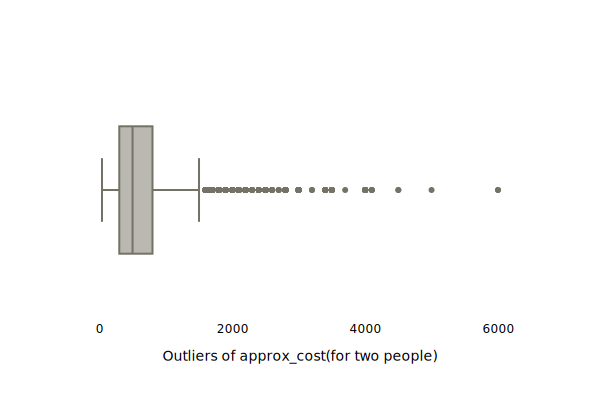

In [8]:
fig = px.box(data_frame = df, x = 'approx_cost(for two people)', color_discrete_sequence = ['#747264'])
fig.update_layout(height = 400, width = 600, plot_bgcolor = '#ffffff', font = dict(color = 'black'))
fig.update_xaxes(title = 'Outliers of approx_cost(for two people)')
fig.show(renderer = 'svg')

>**Note:** We will use RobustScaler to handle this outliers

### Create Pipline with models to determine which models to tune.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [10]:
X = df.drop('success', axis = 1)
y = df['success']

In [11]:
Encoders = ColumnTransformer(transformers = [('OHE', OneHotEncoder(sparse_output = False, drop = 'first'), ['online_order', 'book_table']),
                                             ('BE', BinaryEncoder(), ['location', 'listed_in(type)', 'listed_in(city)'])],
                                             remainder = 'passthrough')

In [12]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('XG', XGBClassifier()))

In [13]:
for model in models:
    steps = []
    steps.append(('Encoders', Encoders))
    steps.append(('Scaler', RobustScaler()))
    steps.append(model)
    pipline = Pipeline(steps = steps)
    result = cross_validate(pipline, X, y, scoring = 'accuracy', cv = 5, return_train_score = True)
    print(f"{model[0]} has Mean Training accuracy {result['train_score'].mean()}")
    print(f"{model[0]} has Mean Testing accuracy {result['test_score'].mean()}")
    print('*' * 70)

LR has Mean Training accuracy 0.6825274623995867
LR has Mean Testing accuracy 0.6753205978746198
**********************************************************************
DT has Mean Training accuracy 0.898892682519047
DT has Mean Testing accuracy 0.7536960108758766
**********************************************************************
RF has Mean Training accuracy 0.898892682519047
RF has Mean Testing accuracy 0.7543836864192496
**********************************************************************
KNN has Mean Training accuracy 0.7935449312667977
KNN has Mean Testing accuracy 0.7156177377608698
**********************************************************************
XG has Mean Training accuracy 0.8017056671839882
XG has Mean Testing accuracy 0.7273315143445286
**********************************************************************


>**Notes:**
>- We did a base pipline we notice that there is overfitting in the training score.
>- In test score we have RandomForest as a highest accuracy we are going to tune it in next file.